In [1]:
import warnings
warnings.filterwarnings(action="ignore")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 

In [2]:
# Initialization
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 100
BATCH_SIZE = 8192

In [3]:
class MyDataset(Dataset):
    def __init__(self, features, targets, weights):
        super(MyDataset, self).__init__()
        self.features = features
        self.targets = targets
        self.weights = weights
        
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        # print(self.targets)
        x = torch.FloatTensor(self.features[idx])
        y = torch.LongTensor(self.targets[idx])
        w = torch.FloatTensor(self.weights[idx])
        return x, y, w


In [4]:
class DNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, output_size)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(512)
        self.bn4 = nn.BatchNorm1d(256)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc4(x))
        x = self.bn4(x)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc5(x))
        return x


In [5]:
def train(model, train_loader, optimizer):
    global class_weights
    model.train()
    train_loss = 0.
    correct = 0
    N_sig = 0. 
    N_bkg = 0. 
    for batch_idx, (data, target, weight) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        class_weights = class_weights.to(DEVICE)
        target = target.view(len(target))
        class_weights = class_weights.view(len(class_weights))
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target, class_weights)
        #print(type(loss), loss)
        loss.backward()
        optimizer.step()
        train_loss += loss

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

        for idx in range(len(pred)):
            #print(pred[idx])
            if pred[idx] == 0:
                if target[idx] == 0:
                    N_sig += weight[idx]
                else:
                    N_bkg += weight[idx]

    train_loss /= len(train_loader.dataset)/BATCH_SIZE
    train_loss = train_loss.cpu()
    train_loss = train_loss.detach().numpy()
    train_accuracy = 100.*correct / len(train_loader.dataset)
    
    N_sig, N_bkg = N_sig.cpu(), N_bkg.cpu()
    significance = N_sig / np.sqrt(N_bkg)
    print(f'[{epoch}] Train Loss: {train_loss}, Train Accuracy: {train_accuracy}%')
    print(f'[{epoch}] Train significance: {significance}')
    return (train_loss, train_accuracy, significance)

In [6]:
def evaluate(model, test_loader):
    global class_weights
    model.eval()
    test_loss = 0
    correct = 0
    N_sig = 0. 
    N_bkg = 0. 
    with torch.no_grad():
        for data, target, weight in test_loader:
            data, target, weight = data.to(DEVICE), target.to(DEVICE), weight.to(DEVICE)
            class_weights = class_weights.to(DEVICE)
            target = target.view(len(target))
            output = model(data)
            test_loss += F.cross_entropy(output, target, class_weights, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            for idx in range(len(pred)):
                if pred[idx] == 0:
                    if target[idx] == 0:
                        N_sig += weight[idx]
                    else:
                        N_bkg += weight[idx]
        
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct / len(test_loader.dataset)

    if N_sig == 0 or N_bkg == 0:
        significance = 0.
    else:
        N_sig, N_bkg = N_sig.cpu(), N_bkg.cpu()
        significance = N_sig / np.sqrt(N_bkg)

    print(f'[{epoch}] Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%')
    print(f'[{epoch}] Test significance: {significance}\n')
    return (test_loss, test_accuracy, significance)

In [7]:
signal = pd.read_csv("Outputs/1E2Mu/TTToHcToWA_AToMuMu_MHc130_MA90.csv", index_col=0)
fake = pd.read_csv("Outputs/1E2Mu/fake.csv", index_col=0)
rare = pd.read_csv("Outputs/1E2Mu/rare.csv", index_col=0)
VV = pd.read_csv("Outputs/1E2Mu/VV.csv", index_col=0)
ttX = pd.read_csv("Outputs/1E2Mu/ttX.csv", index_col=0)
DY = pd.read_csv("Outputs/1E2Mu/DY.csv", index_col=0)
ZG = pd.read_csv("Outputs/1E2Mu/ZG.csv", index_col=0)

In [8]:
signal['label'] = 0
fake['label'] = 1
rare['label'] = 1
VV['label'] = 1
ttX['label'] = 1
DY['label'] = 1
ZG['label'] = 1

In [9]:
sample = pd.concat([signal, fake, rare, VV, ttX, DY, ZG])
sample.describe()

,mu1_pt,mu1_eta,mu1_phi,mu2_pt,mu2_eta,mu2_phi,ele_pt,ele_eta,ele_phi,j1_pt,...,j3_phi,j3_btagScore,MA,Mlll,Mmumuj,Mmumujj,Nj,Nb,weight,label
count,170681.000000,170681.000000,170681.000000,170681.000000,170681.000000,170681.000000,170681.000000,170681.000000,170681.000000,170681.000000,...,170681.000000,170681.000000,170681.000000,170681.000000,170681.000000,170681.000000,170681.000000,170681.000000,170681.000000,170681.000000
mean,98.838163,-0.005878,-0.001970,43.343197,-0.006157,-0.008620,59.395877,-0.005960,-0.017603,138.068210,...,-0.004121,0.273303,89.985795,198.251191,308.953569,458.049876,4.247104,1.603957,0.006047,0.896520
std,69.830803,1.026578,1.808825,32.292281,1.090848,1.814420,48.590473,1.077570,1.808093,102.520707,...,1.664038,0.380215,50.558697,118.628163,195.761651,278.716383,1.699550,0.688380,0.095943,0.304585
min,10.194955,-2.399911,-3.141558,10.000100,-2.399864,-3.141580,10.000332,-2.499689,-3.141568,20.174911,...,-3.141574,0.000000,12.001610,18.940428,29.147986,58.420037,2.000000,1.000000,-3.140052,0.000000
25%,53.873531,-0.748172,-1.564499,22.661364,-0.803978,-1.582672,27.688801,-0.782759,-1.586304,73.592293,...,-1.287987,0.005636,79.396080,119.376018,181.683516,274.514087,3.000000,1.000000,0.000228,1.000000
50%,79.388458,-0.008093,0.002894,34.793743,-0.003954,-0.012798,45.488976,-0.004968,-0.033143,111.003029,...,0.000000,0.036669,89.959244,166.576167,257.512615,384.709116,4.000000,2.000000,0.001789,1.000000
75%,122.238342,0.735766,1.560876,52.547043,0.793383,1.559886,74.777756,0.763521,1.536725,169.920288,...,1.269623,0.517069,92.669652,239.830071,375.748208,557.740895,5.000000,2.000000,0.002755,1.000000
max,1275.796509,2.399920,3.141579,484.303314,2.399999,3.141590,997.658203,2.499850,3.141578,1667.275635,...,3.141573,0.999999,1617.587641,2031.681325,2869.607613,4382.586432,15.000000,7.000000,16.684151,1.000000


In [10]:
print(len(sample))
print(len(signal))
print((len(sample)/len(signal))/(len(sample)/(len(sample)-len(signal))))

170681
17662
8.663741365643755


In [11]:
class_weights = list()
#class_weights.append(signal['weight'].sum())
#class_weights.append(fake['weight'].sum())
#class_weights.append(VV['weight'].sum())
#class_weights.append(ttX['weight'].sum())
#class_weights.append(rare['weight'].sum() + DY['weight'].sum() + ZG['weight'].sum())
#class_weights[0] *= sum(class_weights[1:])/class_weights[0]
#s_weights = sum(class_weights)
#class_weights = [x/s_weights for x in class_weights]
#class_weights[0] = 0.5
#class_weights[3] = 0.3
#class_weights = torch.FloatTensor(class_weights)
#print(class_weights)

class_weights.append(len(signal))
class_weights.append(len(sample) - len(signal))
class_weights = [x/len(sample) for x in class_weights]
class_weights = [1/x for x in class_weights]
class_weights = torch.FloatTensor(class_weights)
print(class_weights)

tensor([9.6637, 1.1154])


In [12]:
scaler = MinMaxScaler()

features = sample[['MA', 'Mlll', 'Mmumuj', 'Mmumujj', 'Nj', 'Nb']].to_numpy()
scaler.fit(features)
targets = sample[['label']].to_numpy()
weights = sample[['weight']].to_numpy()

In [13]:
def train_test_split(features, targets, weights, train_size=0.75, shuffle=True):
    # shuffle first
    if shuffle:
        shuf_features = list()
        shuf_targets = list()
        shuf_weights = list()
        shuf_idx = np.arange(len(targets))
        np.random.shuffle(shuf_idx)
        for idx in shuf_idx:
            shuf_features.append(features[idx])
            shuf_targets.append(targets[idx])
            shuf_weights.append(weights[idx])
        features = shuf_features
        targets = shuf_targets
        weights = shuf_weights 

    split = int(len(targets)*train_size)
    train_features, test_features = features[:split], features[split:]
    train_targets, test_targets = targets[:split], targets[split:]
    train_weights, test_weights = weights[:split], weights[split:]

    return (train_features, test_features, train_targets, test_targets, train_weights, test_weights)


In [14]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(features, targets, weights, train_size=0.75, shuffle=True)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

train_dataset = MyDataset(X_train, y_train, w_train)
test_dataset = MyDataset(X_test, y_test, w_test)

# already shuffled in spliting stage, no need to shuffle
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

In [15]:
model = DNN(6, 2).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
history = dict()
history['loss'] = []
history['acc'] = []
history['val_loss'] = []
history['val_acc'] = []
history['sign'] = []
history['val_sign'] = []
for epoch in range(1, EPOCHS+1):
    loss, accuracy, sign = train(model, train_loader, optimizer)
    scheduler.step()
    test_loss, test_accuracy, test_sign = evaluate(model, test_loader)
    history['loss'].append(loss)
    history['acc'].append(accuracy)
    history['sign'].append(sign)
    history['val_loss'].append(test_loss)
    history['val_acc'].append(test_accuracy)
    history['val_sign'].append(test_sign)

[1] Train Loss: 0.7086225152015686, Train Accuracy: 38.138426685415205%
[1] Train significance: tensor([2.8360])
[1] Test Loss: 1.5617489719214308, Test Accuracy: 67.75796208197605%
[1] Test significance: tensor([0.9993])

[2] Train Loss: 0.6270586848258972, Train Accuracy: 45.80345285524568%
[2] Train significance: tensor([2.8073])
[2] Test Loss: 1.6538872581697024, Test Accuracy: 87.25129479037285%
[2] Test significance: tensor([0.0968])

[3] Train Loss: 0.5853055119514465, Train Accuracy: 47.761112413092725%
[3] Train significance: tensor([2.8673])
[3] Test Loss: 1.4172096832633698, Test Accuracy: 67.9430995289541%
[3] Test significance: tensor([0.7630])

[4] Train Loss: 0.5626806020736694, Train Accuracy: 49.44613702054527%
[4] Train significance: tensor([2.9390])
[4] Test Loss: 1.2245151253101492, Test Accuracy: 57.816784232851354%
[4] Test significance: tensor([1.3099])

[5] Train Loss: 0.548983633518219, Train Accuracy: 50.95617529880478%
[5] Train significance: tensor([2.9671])

KeyboardInterrupt: 

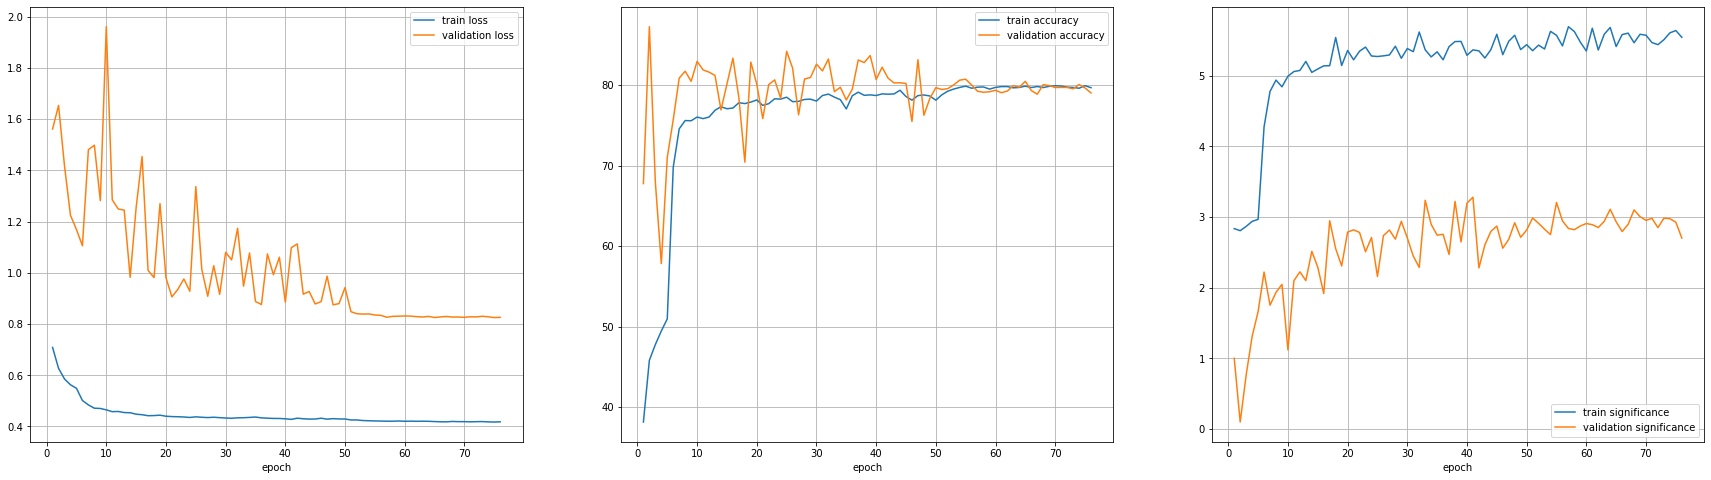

In [19]:
import matplotlib.pyplot as plt

epochs = np.arange(1, 76+1)

plt.figure(figsize=(30, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="validation loss")
plt.xlabel("epoch")
plt.legend(loc='best')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs, history['acc'], label="train accuracy")
plt.plot(epochs, history['val_acc'], label="validation accuracy")
plt.xlabel("epoch")
plt.legend(loc='best')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, history['sign'], label='train significance')
plt.plot(epochs, history['val_sign'], label='validation significance')
plt.xlabel("epoch")
plt.legend(loc='best')
plt.grid(True)
plt.show()
